In [2]:
from helpers import *
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [6]:
# get the data
articles, categories, links, paths_finished, paths_unfinished, paths_all, shortest_path_distance = load_data()

#remove the paths that has only a starting point and are not of our interest
paths_unfinished = paths_unfinished[paths_unfinished.pathLength > 1]

# Create the graphs of interest
G_paths, G_links = get_graphs(paths_all,links)
G_paths_finished, _ = get_graphs(paths_finished,links)
G_paths_unfinished, _ = get_graphs(paths_unfinished,links)

In [7]:
# Get the number of finished and unfinished node_visited 
nb_finished_node_visited = paths_finished.pathLength.sum()
nb_unfinished_node_visited = paths_unfinished.pathLength.sum()
nb_finished_node_visited, nb_unfinished_node_visited

(346778, 124081)

In [8]:
def get_in_out_degree(G, page) :
    in_deg = G.in_degree(page, 'weight')
    in_deg = in_deg if in_deg else 0
    out_deg = G.out_degree(page, 'weight')
    out_deg = out_deg if out_deg else 0
    
    return [in_deg, out_deg]
get_in_out_degree(G_paths, 'Áedán_mac_Gabráin') 

[0, 0]

## Construct the df for the categories with the variables of interest

In [9]:
def add_in_out_deg(cat, G):
    cat['in_deg'] = cat.article.apply(
        lambda art: get_in_out_degree(G, art)[0])
    cat['out_deg'] = cat.article.apply(
        lambda art: get_in_out_degree(G, art)[1])
    cat['mean_in_out_deg'] = (cat['in_deg']+cat['out_deg'])/2
    return cat

def split_cat(cat):
    cat['splitted_cat'] = cat.category.apply(lambda x : x.split('.')[1:])
    return cat

def get_sum_in_out_by_cat(cat):
    cat = cat.explode('splitted_cat')
    cat = cat.groupby('splitted_cat').apply(lambda x : pd.Series({
        'sum_in_deg' : x.in_deg.sum(),
        'sum_out_deg' : x.out_deg.sum(),
        'sum_mean_in_out_deg' : x.mean_in_out_deg.sum() 
    }))
    return cat

def get_cat_summary(cat, G):
    cat = add_in_out_deg(cat, G)
    cat = split_cat(cat)
    cat = get_sum_in_out_by_cat(cat)
    return cat
categories_finished = categories.copy()
categories_unfinished = categories.copy()

categories_finished= get_cat_summary(categories_finished, G_paths_finished)
categories_unfinished= get_cat_summary(categories_unfinished, G_paths_unfinished)

# Divide the sums by the number of node and multiply by 1000 so that it is easier to read
categories_finished = categories_finished/nb_finished_node_visited*1000
categories_unfinished = categories_unfinished/nb_unfinished_node_visited*1000

categories_finished = categories_finished.rename(columns = {'sum_in_deg'  : 'frac_in_deg_finished',
                                                  'sum_out_deg' : 'frac_out_deg_finished',
                                                  'sum_mean_in_out_deg' : 'frac_mean_in_out_deg_finished'})
categories_unfinished = categories_unfinished.rename(columns ={'sum_in_deg'  : 'frac_in_deg_unfinished',
                                                  'sum_out_deg' : 'frac_out_deg_unfinished',
                                                  'sum_mean_in_out_deg' : 'frac_mean_in_out_deg_unfinished'})

In [10]:
categories_finished

,frac_in_deg_finished,frac_out_deg_finished,frac_mean_in_out_deg_finished
splitted_cat,,,
Actors_models_and_celebrities,0.565203,0.997756,0.781480
African_Countries,11.154110,10.231330,10.692720
African_Geography,24.892006,24.243176,24.567591
Air_and_Sea_transport,2.015699,2.099326,2.057512
Ancient_History_Classical_History_and_Mythology,14.320401,14.282913,14.301657
...,...,...,...
Theatre,2.707784,5.516498,4.112141
USA_Presidents,5.017619,3.901632,4.459625
Websites_and_the_Internet,5.813518,5.943284,5.878401


In [11]:
#We join all the categories
categories_all = categories_finished.join(categories_unfinished)

In [19]:
categories_all['diff_in'] = categories_all.apply(lambda x: 
            (x.frac_in_deg_finished - x.frac_in_deg_unfinished) , axis = 1)
categories_all['diff_out'] = categories_all.apply(lambda x: 
            (x.frac_out_deg_finished - x.frac_out_deg_unfinished), axis = 1)
categories_all['diff_mean_in_out'] = categories_all.apply(lambda x: 
            (x.frac_mean_in_out_deg_finished - x.frac_mean_in_out_deg_unfinished), axis = 1)
categories_all['weighted_diff_in'] = categories_all.apply(lambda x: 
            (x.frac_in_deg_finished - x.frac_in_deg_unfinished) /(x.frac_in_deg_finished + x.frac_in_deg_unfinished), axis = 1)
categories_all['weighted_diff_out'] = categories_all.apply(lambda x: 
            (x.frac_out_deg_finished - x.frac_out_deg_unfinished) /(x.frac_out_deg_finished + x.frac_out_deg_unfinished), axis = 1)
categories_all['weighted_diff_mean_in_out'] = categories_all.apply(lambda x: 
            (x.frac_mean_in_out_deg_finished - x.frac_mean_in_out_deg_unfinished)/(x.frac_mean_in_out_deg_finished + x.frac_mean_in_out_deg_unfinished), axis = 1)
categories_all['frac_finished_for_degree'] = categories_all.apply(lambda x: 
            (x.frac_mean_in_out_deg_finished)/(x.frac_mean_in_out_deg_finished + x.frac_mean_in_out_deg_unfinished), axis = 1)

categories_all['diff_finished'] = categories_all.apply(lambda x: 
            (x.frac_in_deg_finished - x.frac_out_deg_finished) , axis = 1)
categories_all['diff_unfinished'] = categories_all.apply(lambda x: 
            (x.frac_in_deg_finished - x.frac_out_deg_unfinished), axis = 1)
categories_all['weighted_diff_finished'] = categories_all.apply(lambda x: 
            (x.frac_in_deg_finished - x.frac_out_deg_finished)/(x.frac_in_deg_finished + x.frac_out_deg_finished) , axis = 1)
categories_all['weighted_diff_unfinished'] = categories_all.apply(lambda x: 
            (x.frac_in_deg_finished - x.frac_out_deg_unfinished)/(x.frac_in_deg_finished + x.frac_out_deg_finished), axis = 1)

In [13]:
categories_all[['weighted_diff_mean_in_out', 'weighted_diff_finished', 'weighted_diff_unfinished']].head(5)

,weighted_diff_mean_in_out,weighted_diff_finished,weighted_diff_unfinished
splitted_cat,,,
Actors_models_and_celebrities,-0.089372,-0.276753,-0.370586
African_Countries,0.093893,0.043150,0.130774
African_Geography,0.118387,0.013205,0.123775
Air_and_Sea_transport,-0.036244,-0.020322,-0.111419
Ancient_History_Classical_History_and_Mythology,-0.011678,0.001311,0.008422


## Difference between of node in/out degree between finished and unfineshed graphs 

Now that we have all the features we needed we can start looking at results. 

First we plot the difference between finished and unfineshed graphs of node degree (that we set to $\frac{deg_{in}+deg_{out}}{2}$). The node degree can be seen as how many time we use the concept during a game. If the difference between finished and unfinished of a concept degree is high it means that the concept is more used in finished paths than in unfinished and that maybe players should go more to this concept page to improve the finished game rate. On the other hand, a big negative difference would mean that this concept should be avoided.

_Note_ : We have to be carefull with the results because maybe it is not the choice of the player to go to these concepts but he might have been forced by the starting or target page. We analyse this deeper in a later section. However, this would already tell us that concepts might be harder than others 

### Histogram of the absolute difference  between finished and unfineshed graphs of node degree

We can see that there are no concepts where people get more stuck in unfinished paths than in finished. However, we can see that finished paths have concepts where we can go that may be more useful and help the players find their way.

However, we have to be carefull because maybe the difference of 10 is between 610 and 600 which does not mean the same thing as the difference between 5 and 15. Therefore we divide the node degree by the sum of degrees.

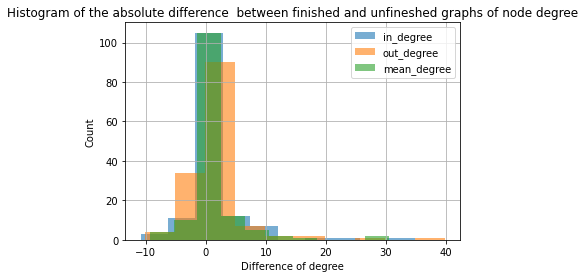

In [17]:
def get_first_last(n, df, cat):
    df_sorted_cat = df[cat].sort_values().index
    return df_sorted_cat[-n :][::-1], df_sorted_cat[:n]

categories_all.diff_in.hist(alpha = 0.6, label = 'in_degree').set_title('Histogram of the absolute difference  between finished and unfineshed graphs of node degree')
categories_all.diff_out.hist(alpha = 0.6, label = 'out_degree')
categories_all.diff_mean_in_out.hist(alpha = 0.6, label = 'mean_degree')
plt.xlabel('Difference of degree')
plt.ylabel('Count')
plt.legend()

### Histogram of the weighted difference between of node in/out degree between finished and unfineshed graphs

From this we can see that there are some concepts that are more used in the unfinished paths that are all related to art/movies/theatre. On the other hand, some concepts like History/chemistry are more used in finished paths.


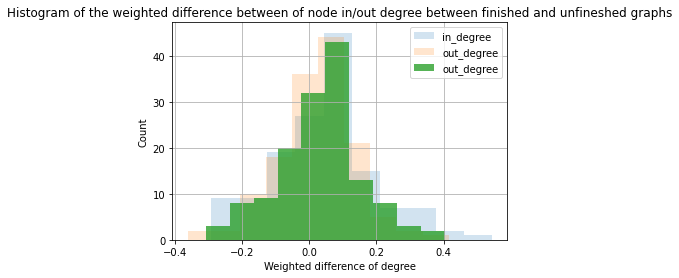

In [24]:
categories_all.weighted_diff_in.hist(alpha = 0.2, label = 'in_degree').set_title('Histogram of the weighted difference between of node in/out degree between finished and unfineshed graphs')
categories_all.weighted_diff_out.hist(alpha = 0.2, label = 'out_degree')
categories_all.weighted_diff_mean_in_out.hist(alpha = 0.8, label = 'out_degree')

plt.xlabel('Weighted difference of degree')
plt.ylabel('Count')
plt.legend()

In [486]:
get_first_last(8, categories_all, 'weighted_diff_mean_in_out')

(Index(['General_Chemistry', 'Chemical_elements', 'Chemistry', 'Software',
        'Middle_Eastern_Countries', 'Dinosaurs', 'Monarchs_of_Great_Britain',
        'Musical_Instruments'],
       dtype='object', name='splitted_cat'),
 Index(['Theatre', 'Literature_types', 'Community_organisations',
        'Architecture', 'Railway_transport',
        'Producers_directors_and_media_figures', 'Sports', 'Films'],
       dtype='object', name='splitted_cat'))

### Histogram of the fraction of use of the concept in finished path over all the time it was used

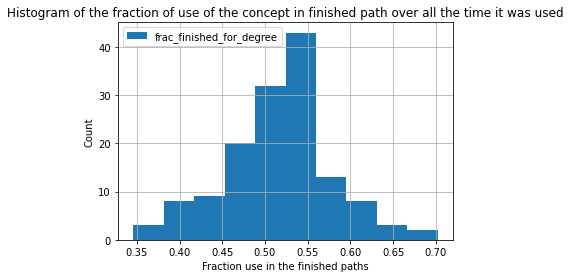

In [25]:
categories_all.frac_finished_for_degree.hist(label = 'frac_finished_for_degree').set_title('Histogram of the fraction of use of the concept in finished path over all the time it was used')
plt.xlabel('Fraction use in the finished paths')
plt.ylabel('Count')
plt.legend()

In [23]:
get_first_last(10, categories_all, 'frac_finished_for_degree')

(Index(['General_Chemistry', 'Chemical_elements', 'Chemistry', 'Software',
        'Middle_Eastern_Countries', 'Dinosaurs', 'Monarchs_of_Great_Britain',
        'Musical_Instruments',
        'British_History_1500_and_before_including_Roman_Britain',
        'Antarctica'],
       dtype='object', name='splitted_cat'),
 Index(['Theatre', 'Literature_types', 'Community_organisations',
        'Architecture', 'Railway_transport',
        'Producers_directors_and_media_figures', 'Sports', 'Films',
        'Television', 'General_Literature'],
       dtype='object', name='splitted_cat'))

### Histogram of the weighted difference between of node in/out degree of big concepts between finished and unfineshed graphs
Finally we want to see only the difference in big concepts - concepts that often appear. For this we reduced the concepts we look at to only concepts that have at least 100 of in_degree.

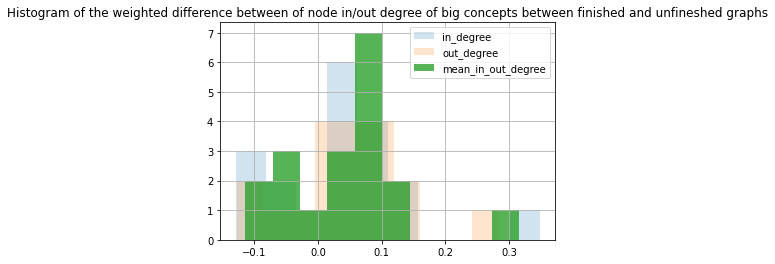

In [29]:
min_deg = 1000* 1/40 
categories_all[categories_all.frac_mean_in_out_deg_finished > min_deg].weighted_diff_in.hist(alpha = 0.2, label = 'in_degree').set_title('Histogram of the weighted difference between of node in/out degree of big concepts between finished and unfineshed graphs')
categories_all[categories_all.frac_mean_in_out_deg_finished > min_deg].weighted_diff_out.hist(alpha = 0.2, label = 'out_degree')
categories_all[categories_all.frac_mean_in_out_deg_finished > min_deg].weighted_diff_mean_in_out.hist(alpha = 0.8, label = 'mean_in_out_degree')
plt.legend()

In [30]:
categories_all[categories_all.frac_mean_in_out_deg_finished > min_deg][categories_all['weighted_diff_mean_in_out'] >0.05].weighted_diff_in.sort_values(ascending = False).index

C:\Users\mathi\AppData\Local\Temp/ipykernel_31944/3536877378.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  categories_all[categories_all.frac_mean_in_out_deg_finished > min_deg][categories_all['weighted_diff_mean_in_out'] >0.05].weighted_diff_in.sort_values(ascending = False).index


Index(['Chemistry', 'British_History', 'Physics', 'People', 'Science',
       'European_Geography', 'History', 'European_Countries',
       'General_Geography', 'Geography', 'Countries'],
      dtype='object', name='splitted_cat')

In [31]:
categories_all[categories_all.frac_mean_in_out_deg_finished > min_deg][categories_all['weighted_diff_mean_in_out'] < -0.015].weighted_diff_in.sort_values(ascending = False).index

C:\Users\mathi\AppData\Local\Temp/ipykernel_31944/4094025566.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  categories_all[categories_all.frac_mean_in_out_deg_finished > min_deg][categories_all['weighted_diff_mean_in_out'] < -0.015].weighted_diff_in.sort_values(ascending = False).index


Index(['Citizenship', 'Everyday_life', 'North_American_Geography',
       'Language_and_literature', 'General_Biology'],
      dtype='object', name='splitted_cat')

## Look at the difference between in and out degree in finished and unfinished paths 
diff = in_deg- out_deg. It implies that 
- if diff is big, it means that we came to this node but then came back to the previous one 
- if diff is small, it means that we get back and forth from this node not knowing how to escape

First, we see that nodes for finished paths are more balanced, which means the go back button was not used much in these concepts, whereas for unfinished paths it is skewed right but also to the left.

From this we see that we have both cases with unfinished paths and what is interesting is that the 
- the node they go to and then come back are the node used more in finished paths like politics/history/chemistry, which means that maybe they don't adopt the good strategy and should have continued in this direction.
- The node they cannot escape are the ones related to litterature which are the node used less in finished than in unfinished. So we might conclude that the players should escapte these node as soon as possible.

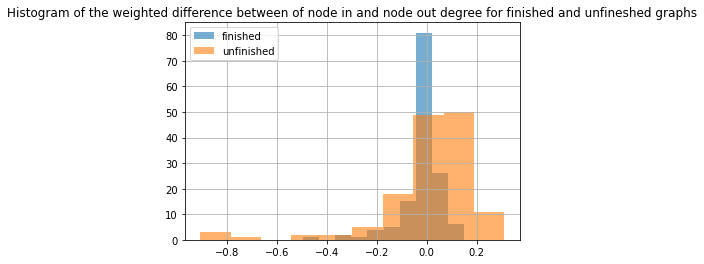

In [490]:
categories_all.weighted_diff_finished.hist(alpha = 0.6, label = 'finished').set_title('Histogram of the weighted difference between of node in and node out degree for finished and unfineshed graphs')
categories_all.weighted_diff_unfinished.hist(alpha = 0.6, label = 'unfinished')
plt.legend()

In [491]:
get_first_last(10, categories_all, 'weighted_diff_unfinished')

(Index(['General_Chemistry', 'Chemical_elements',
        'British_History_1500_and_before_including_Roman_Britain', 'Chemistry',
        'Software', 'Middle_Eastern_Countries', 'Musical_Instruments',
        'Monarchs_of_Great_Britain', 'Geography_of_the_Middle_East',
        'World_War_II'],
       dtype='object', name='splitted_cat'),
 Index(['Theatre', 'Architecture', 'Literature_types', 'Cartoons',
        'Producers_directors_and_media_figures', 'Railway_transport',
        'Actors_models_and_celebrities', 'General_Literature', 'Films',
        'Television'],
       dtype='object', name='splitted_cat'))

## Use Bokeh to plot results 

In [492]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool, ColorBar, ColorMapper,Range1d
output_notebook()
def get_color(x):
    if x.weighted_diff_mean_in_out < -0.3 or x.weighted_diff_unfinished < -0.3 :
        return 'red'
    elif x.weighted_diff_mean_in_out > 0.3 or x.weighted_diff_unfinished > 0.3 :
        return 'green'
    else :
        return 'blue'

Loading BokehJS ...

In [493]:
data = categories_all[['weighted_diff_unfinished', 'weighted_diff_mean_in_out']].reset_index()
data['color'] = data.apply(lambda x : get_color(x), axis = 1)
hover = HoverTool(
    tooltips=[
        ("Name", "@splitted_cat"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=760, plot_height=360, tools=tools, title="Comparing nodes used in un-finished paths and their percentage difference of in and out degree")
p.title.text_color = "black"
p.title.text_font_size = "15px"
p.xaxis.axis_label = 'Percentage difference of number of time node used in finished and unfinished paths'
p.yaxis.axis_label = 'Percentage difference of in and out degree for unfinished paths'

p.x_range = Range1d(-1,1)
p.y_range = Range1d(-1,1)

p.circle('weighted_diff_mean_in_out', 'weighted_diff_unfinished', color = 'color', source=data, size=15, alpha=0.5)

show(p, notebook_handle=True)

## Comparing subject of starting and end points 

In [494]:
categories['categories'] = categories.category.apply(lambda x : x.split('.')[1:])
categories_merged = pd.DataFrame(categories.groupby('article').categories.agg(sum))
#categories_merged = categories_merged.reset_index()

In [495]:
def get_categories(article, df):
    if article not in df.index :
        return [] 
    else : 
        return df.loc[article].categories

def get_start_target_cats(paths):
    paths['start'] = paths.path.apply(lambda x:x.split(';')[0])
    paths['start_cats'] = paths['start'].apply(lambda article : get_categories(article, categories_merged))
    paths['target_cats'] = paths['target'].apply(lambda article : get_categories(article, categories_merged))
    paths_start = paths.explode('start_cats').groupby('start_cats').start.agg(len)
    paths_target = paths.explode('target_cats').groupby('target_cats').target.agg(len)
    paths_out = pd.merge(paths_start, paths_target, right_index=True, left_index=True)
    return paths_out
    
start_target_cats_unfinished = get_start_target_cats(paths_unfinished[['path', 'target']].copy())
start_target_cats_finished = get_start_target_cats(paths_finished[['path', 'target']].copy())

In [496]:
start_target_cats_finished = start_target_cats_finished/nb_finished_node_visited*1000
start_target_cats_unfinished = start_target_cats_unfinished/nb_unfinished_node_visited*1000

start_target_cats_finished = start_target_cats_finished.add_suffix('_finished')
start_target_cats_unfinished = start_target_cats_unfinished.add_suffix('_unfinished')

In [497]:
start_target_cats = start_target_cats_finished.join(start_target_cats_unfinished)

In [498]:
start_target_cats['weighted_diff_start'] = start_target_cats.apply(lambda x: 
            (x.start_finished - x.start_unfinished) /(x.start_finished + x.start_unfinished), axis = 1)
start_target_cats['weighted_diff_target'] = start_target_cats.apply(lambda x: 
            (x.target_finished - x.target_unfinished) /(x.target_finished + x.target_unfinished), axis = 1)


### Plot the results
We plot two histograms 
- the histogram of the weighted difference between **starting page** between finished and unfineshed graphs.  
- the histogram of the weighted difference between **target page** between finished and unfineshed graphs.  

#### Starting page 
First we see that the starting page histogram has a smaller variance then the target page histogram. It is not a surprise since we know that the starting pahse of going to a hub is the easiest part. Moreover we cannot say that a starting page is easier but there are still some pages that seems harder to start with `['Architecture', 'Theatre', 'Literature_types', 'General_Biology', 'Language_and_literature', 'Design_and_Technology', 'Air_and_Sea_transport', 'Conflict_and_Peace']`.

#### Target page 
In the target page histogram, we can see a lot of variance and there are topics that seems to be easier or harder than others. We can see that topics with _Geography_ or _countries_ are quiet easy whereas topics more related to _movies_ or to _litterature_ are harder. This we can be quiet sure because we see that the topic `'General_Literature'` has a score of -0.8 where the minimum which means players always fail with this topics is -1.


In [499]:
start_target_cats.loc['General_Literature']

start_finished          0.268183
target_finished         0.109580
start_unfinished        0.317104
target_unfinished       1.268417
weighted_diff_start    -0.083585
weighted_diff_target   -0.840957
Name: General_Literature, dtype: float64

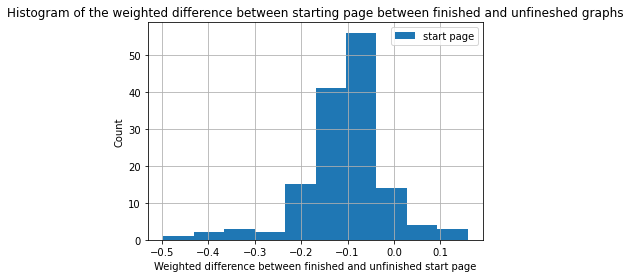

In [500]:
start_target_cats['weighted_diff_start'].hist(label = 'start page').set_title('Histogram of the weighted difference between starting page between finished and unfineshed graphs')
plt.xlabel('Weighted difference between finished and unfinished start page')
plt.ylabel('Count')
plt.legend()

In [501]:
# Get element that seems to be harder as a start page
get_first_last(10, start_target_cats, 'weighted_diff_start')[1]

Index(['Architecture', 'Theatre', 'Literature_types', 'General_Biology',
       'Language_and_literature', 'Design_and_Technology',
       'Air_and_Sea_transport', 'Conflict_and_Peace',
       'Geographers_and_explorers', 'Computer_Programming'],
      dtype='object', name='start_cats')

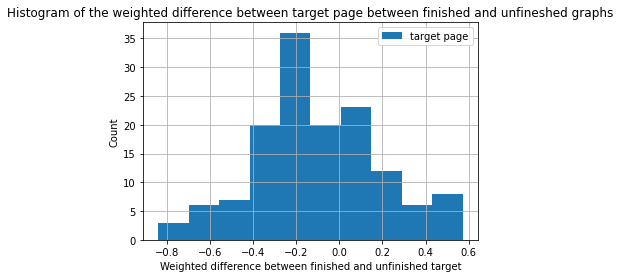

In [502]:
# Look at the target page now
start_target_cats['weighted_diff_target'].hist(label = 'target page').set_title('Histogram of the weighted difference between target page between finished and unfineshed graphs')
plt.xlabel('Weighted difference between finished and unfinished target')
plt.ylabel('Count')
plt.legend()

In [503]:
# Get the easiest and hardest finishing pages
get_first_last(10, start_target_cats, 'weighted_diff_target')

(Index(['European_Countries', 'USA_Presidents', 'European_Geography',
        'Middle_Eastern_Countries', 'Asian_Countries', 'African_Countries',
        'Countries', 'Languages', 'Geography_of_the_Middle_East',
        'African_Geography'],
       dtype='object', name='start_cats'),
 Index(['General_Literature', 'Cartoons', 'Actors_models_and_celebrities',
        'Games', 'Conflict_and_Peace', 'Novels', 'Community_organisations',
        'Television', 'Sports_and_games_people', 'Cryptography'],
       dtype='object', name='start_cats'))

In [504]:
def get_color_2(x):
    if x.weighted_diff_target < -0.5 or x.weighted_diff_start < -0.25 :
        return 'red'
    elif x.weighted_diff_target > 0.3 or x.weighted_diff_start > 0.25 :
        return 'green'
    else :
        return 'blue'
data = start_target_cats[['weighted_diff_start', 'weighted_diff_target']].reset_index()
data['color'] = data.apply(lambda x : get_color_2(x), axis = 1)
hover = HoverTool(
    tooltips=[
        ("Name", "@start_cats"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=660, plot_height=460, tools=tools, title="Comparing sucess of game with start and target topics")
p.title.text_color = "black"
p.title.text_font_size = "15px"
p.xaxis.axis_label = 'Sucess rate with this concept as starting edges'
p.yaxis.axis_label = 'Sucess rate with this concept as target edges'
p.x_range = Range1d(-1,1)
p.y_range = Range1d(-1,1)

p.circle('weighted_diff_start', 'weighted_diff_target', color = 'color', source=data, size=15, alpha=0.5)

show(p, notebook_handle=True)